<a href="https://colab.research.google.com/github/vivitc/deep-learning-books/blob/master/Trabalho_DL_Books.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabalho Deep Learning - Filtragem colaborativa com avaliações de livros**
## Grupo 7
### - Amanda
### - James La Rosa
### - Roger William Calderini
### - Vinícius D`Ambros
### - Viviana Terceros Cordova

Neste notebook, desenvolveremos o trabalho com foco em: 
- Filtragem Colaborativa
- Cold Start

Com isso, busca-se desenvolver um modelo de recomendação que leve em consideração a filtragem colaborativa (avaliações de cada usuário) e drible o cold start identificado.

## 0. Importação das bibliotecas

Upload das bibliotecas que serão utilizadas

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.datasets import mnist

#Visualização
import seaborn as sns
sns.set(style='white', context='notebook', palette='pastel')
#Visualização dos dados
import matplotlib.pyplot as plt

#Used for distribution fitting, and representation
from scipy import stats

#Time measuring for model training
from time import time

#dependência do matplotlib
!pip install msgpack 
#instalação do pacote matplotlib
!pip install matplotlib  
import matplotlib.pyplot as plt 
import pandas as pd  
import statsmodels.api as sm  
import pylab as pl  
import numpy as np  
from patsy import dmatrix  

!pip install wordcloud
from os import path
from PIL import Image

import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Upload da base

Aqui, vamos subir a base 

In [ ]:
import pandas as pd  
url_book_rating = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Book-Ratings01.csv'
df_book_rating = pd.read_csv(url_book_rating, delimiter=";", encoding="latin1")

In [ ]:
display(df_book_rating)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [ ]:
import pandas as pd  
url_book = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Books01.csv'
df_book = pd.read_csv(url_book, delimiter=";", encoding="latin1")

In [ ]:
display(df_book)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271374,440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271375,525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271377,192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [ ]:
import pandas as pd  
url_users = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Users01.csv'
df_users = pd.read_csv(url_users, delimiter=";", encoding="latin1", header=0)

In [ ]:
display(df_users)

,User-ID,Location_CT,Location_UF,Location_CY,Age
0,1,nyc,new york,usa,NaN
1,2,stockton,california,usa,18
2,3,moscow,yukon territory,russia,NaN
3,4,porto,v.n.gaia,portugal,17
4,5,farnborough,hants,united kingdom,NaN
...,...,...,...,...,...
277658,278854,portland,oregon,usa,NaN
277659,278855,tacoma,washington,united kingdom,50
277660,278856,brampton,ontario,canada,NaN
277661,278857,knoxville,tennessee,usa,NaN


## 2. Análise descritiva dos dados
Em seguida, vamos fazer alguns pré-processamentos básicos para conhecer os dados, lembrando os códigos:
- BX-Users: Contém os usuários(`User-ID`) anônimos. Dados demográficos organizados, quando disponíveis (`Location`, `Age`). `Age` com valor NaN, significa que o valor de `Age` nao foi disponibilizado.

- BX-Books: Os livros são identificados pelo ISBN (os inválidos já foram removidos). Informações sobre conteúdo são disponíveis como (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), pelo Amazon Web Services. Se houver mais de 1 autor, só o primeiro é mencionado. Imagens da capa estão disponíveis em pequeno, médio e grande (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), pelo Amazon Web Services também.

- BX-Book-Ratings: As avaliações dos livros (`Book-Rating`)  são ou explícitas de 1-10 (valores mais altos indicam mais apreciação), ou implicito, expresso por 0.


## Aqui precisamos unir os datasets para conseguir correlacionar Ratings com Year of publication, location, age, etc, não? Minha sugestão seria:
- Ratings com Location
- Ratings com idade
- Ratings com Ano de publicação

###2.1 Users (aguardando normalização)

In [ ]:
#Verificando as estatísticas básicas
df_users.describe

<bound method NDFrame.describe of        User-ID  Location_CT       Location_UF      Location_CY  Age
0            1          nyc          new york              usa  NaN
1            2     stockton        california              usa   18
2            3       moscow   yukon territory           russia  NaN
3            4        porto          v.n.gaia         portugal   17
4            5  farnborough             hants   united kingdom  NaN
...        ...          ...               ...              ...  ...
277658  278854     portland            oregon              usa  NaN
277659  278855       tacoma        washington   united kingdom   50
277660  278856     brampton           ontario           canada  NaN
277661  278857    knoxville         tennessee              usa  NaN
277662  278858       dublin               n/a          ireland  NaN

[277663 rows x 5 columns]>

In [ ]:
#Entendendo se temos muitos valores faltantes
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277663 entries, 0 to 277662
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      277663 non-null  object
 1   Location_CT  277106 non-null  object
 2   Location_UF  277663 non-null  object
 3   Location_CY  273090 non-null  object
 4   Age          167330 non-null  object
dtypes: object(5)
memory usage: 10.6+ MB


In [ ]:
total = df_users.isnull().sum().sort_values(ascending = False)
percent = (df_users.isnull().sum()/df_users.isnull().count()*100).sort_values(ascending = False)
missing_df_users  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_users

,Total,Percent
Age,110333,39.736299
Location_CY,4573,1.646961
Location_CT,557,0.200603
Location_UF,0,0.000000
User-ID,0,0.000000


24    5661
25    5602
26    5527
23    5435
27    5367
28    5331
29    5270
32    4767
30    4766
22    4685
33    4684
34    4648
31    4643
21    4415
35    4183
20    4039
19    3936
36    3878
18    3686
37    3573
Name: Age, dtype: int64

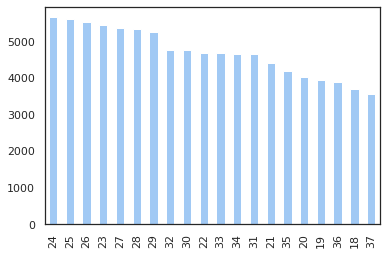

In [ ]:
# Ratings de 0 a 10
Users_Age=df_users["Age"].value_counts(ascending=False)
Users_Age.head(20).plot.bar()
Users_Age.head(20)



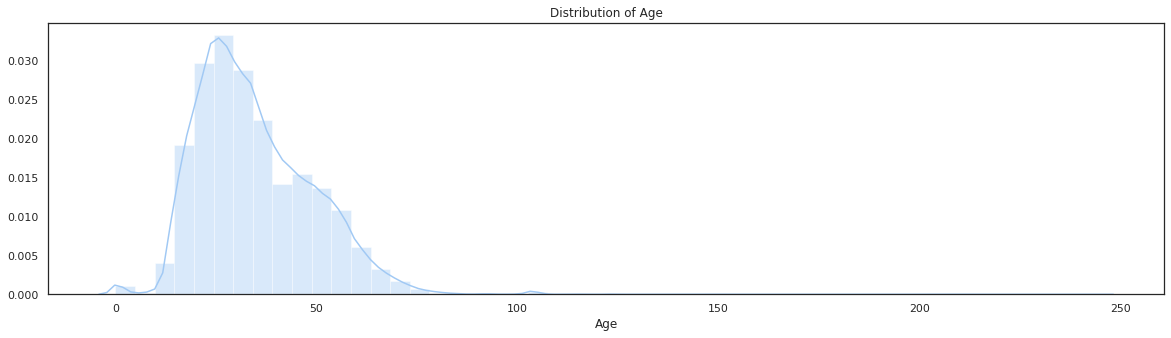

In [ ]:
#Histograma com distribuição de idade
plt.figure(figsize=(20,5))
plt.title("Distribution of Age")
ax = sns.distplot(df_users["Age"])

###2.2 Books

In [ ]:
#Verificando as estatísticas básicas
df_book.describe(exclude=[np.object])

,Year-Of-Publication
count,271379.000000
mean,1959.763394
std,257.983943
min,0.000000
25%,1989.000000
50%,1995.000000
75%,2000.000000
max,2050.000000


In [ ]:
#Entendendo se temos muitos valores faltantes
df_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          271378 non-null  object
 3   Year-Of-Publication  271379 non-null  int64 
 4   Publisher            271377 non-null  object
 5   Image-URL-S          271379 non-null  object
 6   Image-URL-M          271379 non-null  object
 7   Image-URL-L          271379 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.6+ MB


2002    17628
1999    17432
2001    17360
2000    17235
1998    15767
1997    14892
2003    14359
1996    14031
1995    13548
1994    11796
1993    10603
1992     9906
1991     9389
1990     8661
1989     7937
1988     7493
1987     6529
1986     5841
2004     5839
1985     5343
Name: Year-Of-Publication, dtype: int64

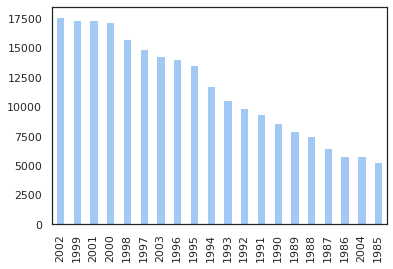

In [ ]:
# Anos de publicação Top 20
Ratings=df_book["Year-Of-Publication"].value_counts(ascending=False)
Ratings.head(20).plot.bar()
Ratings.head(20)



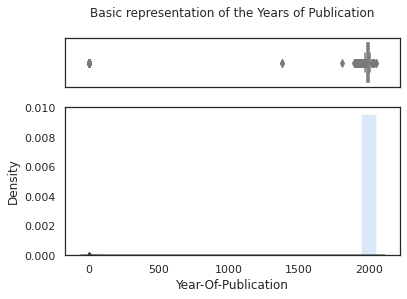

In [ ]:
#Histograma de pontos com toda base

#Subplot grid
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)})
 
#Plot + subplot grid
sns.boxplot(df_book["Year-Of-Publication"], ax=ax_box).set_title("Basic representation of the Years of Publication\n")
sns.distplot(df_book["Year-Of-Publication"], ax=ax_hist, kde=False, fit=stats.gamma, bins=20)
sns.set_color_codes("bright")

#Legendas
ax_box.set(xlabel='') #Remove x axis name for the boxplot
ax_hist.set(ylabel='Density')

plt.show()

In [ ]:
Q3 = np.quantile(df_book["Year-Of-Publication"], 0.75) #Third quartile
Q1 = np.quantile(df_book["Year-Of-Publication"], 0.25) #First quartile
IQR = Q3 - Q1 #Inter Quartile Range
sns.set_color_codes("bright")

outlier_score_threshold =  Q3 + 1.5 * IQR
outlier_number=len(df_book[df_book["Year-Of-Publication"] > outlier_score_threshold ])

print("Number of outliers:", outlier_number,
      "\nOutlier proportion:", round(outlier_number/len(df_book_rating["Book-Rating"])*100, 3),"%",
      "\nOutlier threshold score:", outlier_score_threshold,"/ 100")

Number of outliers: 17 
Outlier proportion: 0.001 % 
Outlier threshold score: 2016.5 / 100


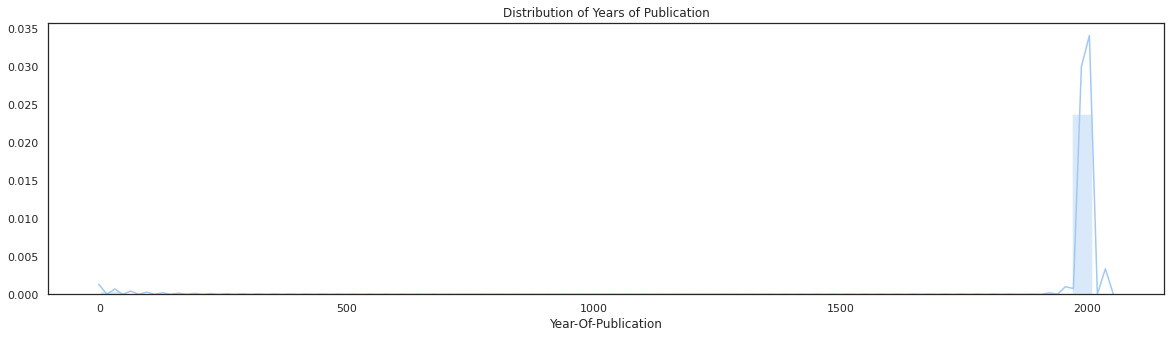

In [ ]:
#Histograma com distribuição dos anos de publicação
plt.figure(figsize=(20,5))
plt.title("Distribution of Years of Publication")
ax = sns.distplot(df_book["Year-Of-Publication"])

###2.3 Books Ratings

In [ ]:
#Verificando as estatísticas básicas
df_book_rating.describe(exclude=[np.object])

ValueError: ignored

In [ ]:
#Entendendo se temos muitos valores faltantes
df_book_rating.info()

In [ ]:
total = df_book_rating.isnull().sum().sort_values(ascending = False)
percent = (df_book_rating.isnull().sum()/df_book_rating.isnull().count()*100).sort_values(ascending = False)
missing_df_book_rating  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_book_rating

In [ ]:
# Ratings de 0 a 10
Ratings=df_book_rating["Book-Rating"].value_counts(ascending=False)
Ratings.head(10).plot.bar()
Ratings.head(10)



In [ ]:
total = df_book_rating["Book-Rating"].value_counts(ascending=False)
percent = (df_book_rating.count()/df_book_rating.count()*100).sort_values(ascending = False)
Ratings_percent  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
Ratings_percent

In [ ]:
#Histograma de pontos com toda base

#Subplot grid
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)})
 
#Plot + subplot grid
sns.boxplot(df_book_rating["Book-Rating"], ax=ax_box).set_title("Basic representation of the Score feature\n")
sns.distplot(df_book_rating["Book-Rating"], ax=ax_hist, kde=False, fit=stats.gamma, bins=20)
sns.set_color_codes("bright")

#Legendas
ax_box.set(xlabel='') #Remove x axis name for the boxplot
ax_hist.set(ylabel='Density')

plt.show()

In [ ]:
Q3 = np.quantile(df_book_rating["Book-Rating"], 0.75) #Third quartile
Q1 = np.quantile(df_book_rating["Book-Rating"], 0.25) #First quartile
IQR = Q3 - Q1 #Inter Quartile Range
sns.set_color_codes("bright")

outlier_score_threshold =  Q3 + 1.5 * IQR
outlier_number=len(df_book_rating[ df_book_rating["Book-Rating"] > outlier_score_threshold ])

print("Number of outliers:", outlier_number,
      "\nOutlier proportion:", round(outlier_number/len(df_book_rating["Book-Rating"])*100, 3),"%",
      "\nOutlier threshold score:", outlier_score_threshold,"/ 100")

In [ ]:
#Histograma com distribuição dos Ratings
plt.figure(figsize=(20,5))
plt.title("Distribution of Ratings")
ax = sns.distplot(df_book_rating["Book-Rating"])

## 3. Desenvolvimento do Cold Start
Estruturar como vamos resolver o problema de cold start

## 4. Desenvolvimento Filtragem Colaborativa
Executaremos a filtragem com DL e sem DL, para depois compararmos as principais métricas:
- MF Accuracy
- F1-score
- Precision
- Recall
- MSE: O loss é root mean squared error loss 
- mean_abs_error: O mean absolute error


### 4.1 - F.C. sem Deep Learning

In [ ]:
merged_user_book_rating = pd.merge(left=df_users, right=df_book_rating, left_on='User-ID', right_on='User-ID')
merged_user_book_rating

### 4.2 - F.C. com Deep Learning

## 5. Comparativo e análise
Verificamos as principais métricas dos dois algoritmos, comparando e identificando diferenças

## 6. Conclusão
Fechamos o trabalho com a percepção final sobre os 2 modelos executados.